In [19]:
!pip install beautifulsoup4

from bs4 import BeautifulSoup
import requests
import pandas as pd

def simpleGoogleSearch(query, start):
    results = []

    query = query.replace(' ', '+')
    URL = f"https://www.google.com/search?q={query}&start={start}"

    # Latest Chrome user-agent
    headers = {
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36"
    }
    resp = requests.get(URL, headers=headers)

    if resp.status_code == 200:
        soup = BeautifulSoup(resp.content, "html.parser")

        for g in soup.find_all('div', class_='tF2Cxc'):
            anchors = g.find_all('a')

            if anchors:
                link = anchors[0]['href']
                title = g.find('h3').text
                item = {"title": title, "link": link}
                results.append(item)

    return results

def googleToPandas(googleQuery):
    resultsCounter = 0
    resultsList = []

    while True:
        pageResults = simpleGoogleSearch(googleQuery, resultsCounter)

        if not pageResults:
            break
        else:
            resultsList.extend(pageResults)
            resultsCounter += 10

    return pd.DataFrame(resultsList)

googleSearchQuery = input("Enter your Google search query: ")
results = googleToPandas(googleSearchQuery)

if not results.empty:
    print("Top search results:")
    print(results)

    # Output data to CSV file
    results.to_csv('GoogleResults.csv', index=False)

    # Output data to TXT file
    with open('GoogleResults.txt', 'w') as f:
        for index, row in results.iterrows():
            f.write(f"{row['title']}: {row['link']}\n")

    print("Results saved to GoogleResults.csv and GoogleResults.txt.")
else:
    print("No search results found.")


Enter your Google search query: Paytm Bank is Close ?
Top search results:
                                                 title  \
0    Paytm Payments Bank closure on March 15 will l...   
1    Paytm Payments Bank to close from March 15. He...   
2      Paytm Payments Bank To Shut Down After March 15   
3    What will happen to my Paytm Payment Bank Acco...   
4    Paytm Payments Bank closes today: What happens...   
..                                                 ...   
155                                       Paytm Hiring   
156  Online Movie Ticket Booking, Showtimes in Chennai   
157  Online Movie Ticket Booking, Showtimes in Udum...   
158  Current Affairs June 2017 eBook - Page 90 - Go...   
159                           Paytm Investor Relations   

                                                  link  
0    https://m.economictimes.com/industry/banking/f...  
1    https://www.livemint.com/companies/news/paytm-...  
2    https://www.ndtv.com/india-news/paytm-payments...  
3

In [ ]:
import requests
from bs4 import BeautifulSoup

def fetch_article_text(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            # Find and concatenate all text elements
            text_elements = soup.find_all(['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
            text = ' '.join(element.get_text() for element in text_elements)
            return text
        else:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error fetching {url}: {e}")
    return None

# Let's assume you already have the DataFrame 'results' from the previous code

# Output data to TXT file with only text content
with open('/content/GoogleResults.txt', 'w', encoding='utf-8') as f:
    for index, row in results.iterrows():
        url = row['link']
        article_text = fetch_article_text(url)
        if article_text:
            f.write(f"Title: {row['title']}\n")
            f.write(f"URL: {url}\n")
            f.write(article_text + "\n\n")
        else:
            f.write(f"Failed to fetch content from: {url}\n\n")

print("Content from article links saved to GoogleResults_Content.txt.")

Failed to fetch https://www.business-standard.com/companies/news/paytm-has-completed-migration-of-all-merchants-to-yes-bank-ceo-sharma-124042201006_1.html. Status code: 403
Failed to fetch https://inc42.com/buzz/regulatory-curbs-on-paytm-bank-puts-its-wallet-business-in-slow-lane/. Status code: 201
Failed to fetch https://www.reuters.com/technology/indias-paytm-up-after-payments-authority-grants-third-party-app-license-2024-03-15/. Status code: 401
Content from article links saved to GoogleResults_Content.txt.


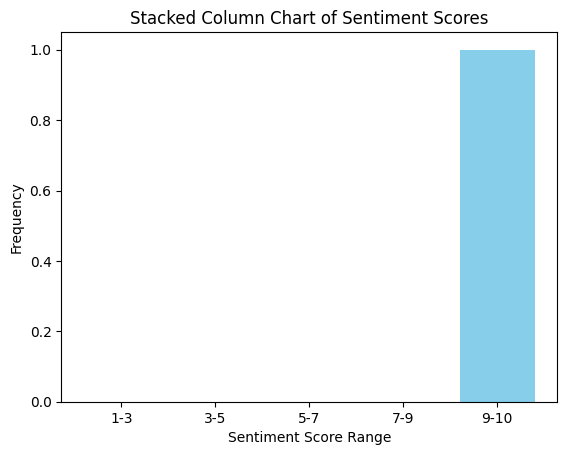

In [21]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np

# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Read text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    return text

# File path
file_path = '/content/GoogleResults.txt'

# Read text from the file
input_text = read_text_from_file(file_path)

# Perform sentiment analysis on the input text
sentiment = analyzer.polarity_scores(input_text)

# Extract compound scores
compound_scores = sentiment['compound']

# Map compound scores from the range -1 to 1 to the range 1 to 10
mapped_scores = np.interp(compound_scores, (-1, 1), (1, 10))

# Categorize sentiment scores into bins
bins = [1, 3, 5, 7, 9, 11]  # define bin edges
bin_labels = ['1-3', '3-5', '5-7', '7-9', '9-10']  # define bin labels
category = np.digitize(mapped_scores, bins, right=True)

# Count frequencies of scores in each bin
frequency = [np.sum(category == i) for i in range(1, len(bins))]

# Plot stacked column chart
plt.bar(bin_labels, frequency, color='skyblue')
plt.xlabel('Sentiment Score Range')
plt.ylabel('Frequency')
plt.title('Stacked Column Chart of Sentiment Scores')
plt.show()


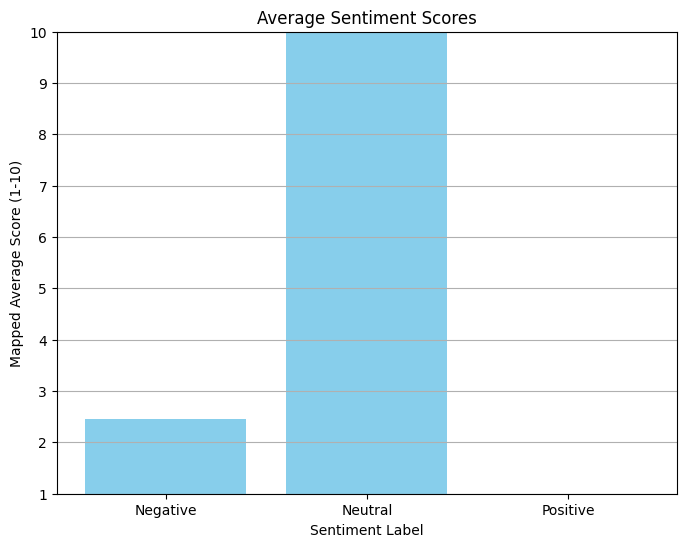

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def perform_sentiment_analysis(tweet):
    tweet_words = []

    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)

    tweet_proc = " ".join(tweet_words)

    # load model and tokenizer
    roberta = "cardiffnlp/twitter-roberta-base-sentiment"
    model = AutoModelForSequenceClassification.from_pretrained(roberta)
    tokenizer = AutoTokenizer.from_pretrained(roberta)

    labels = ['Negative', 'Neutral', 'Positive']

    # sentiment analysis
    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    results = {label: score for label, score in zip(labels, scores)}
    return results

# Read text from a file
def read_text_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

# Map sentiment scores to range 1-10
def map_to_range(scores):
    return 1 + (scores - np.min(scores)) * 9 / (np.max(scores) - np.min(scores))

# File path
file_path = '/content/GoogleResults.txt'  # Update with your file path

# Read text from the file
lines = read_text_from_file(file_path)

# Perform sentiment analysis on each line
results = []
for line in lines:
    line = line.strip()  # Remove leading/trailing whitespace
    if line:  # Skip empty lines
        result = perform_sentiment_analysis(line)
        results.append(result)

# Convert results to DataFrame for easier manipulation and analysis
df = pd.DataFrame(results)

# Calculate average sentiment scores
avg_scores = df.mean()

# Map average scores to range 1-10
mapped_avg_scores = map_to_range(avg_scores)

# Plot bar graph of mapped average scores
plt.figure(figsize=(8, 6))
plt.bar(mapped_avg_scores.index, mapped_avg_scores.values, color='skyblue')
plt.xlabel('Sentiment Label')
plt.ylabel('Mapped Average Score (1-10)')
plt.title('Average Sentiment Scores')
plt.ylim(1, 10)
plt.grid(axis='y')
plt.show()
